<div style="width:90%;
            margin:10px;
            padding:8px;
            border:2px solid #FF0000;
            border-radius:20px;
            font-weight:bold;
            font-size:2.5em;
            text-align:center;">
The Electrical Vehicle Problem
</div>

<div style="width:90%;
            margin:9px;
            font-size:1em;">
            
*The Electrical Vehicle Problem:* This problem consists of an electric vehicles system.     
The problem is inspired from : [PS2011] Nicolas Petit and Antonio Sciarretta. "Optimal drive of electric vehicles using an inversion-based trajectory generation approach." IFAC Proceedings Volumes 44, no. 1 (2011): 14519-14526.      
We solve the problem using the [JuMP](https://jump.dev/) and [OptimalControl](https://control-toolbox.org/OptimalControl.jl/stable/) packages in Julia then we compare the results.

1. [JuMP Formulation](#jump)
2. [OptimalControl Formulation](#oc)
3. [Comparison](#comp)

</div>

In [ ]:
import Pkg
Pkg.activate("..")
include("./utils.jl");
using OptimalControlProblems
using Plots
using MKL
import HSL_jll
nh = 300;

  Activating project at `~/ENSEEIHT/Stage/CTBenchmarks.jl`


## 1. Solving with JuMP <a id='jump'></a>

In [2]:
using JuMP , Ipopt

ECarJMP = electrical_vehicle(JuMPBackend(); nh=nh)

set_optimizer(ECarJMP,Ipopt.Optimizer)
set_attribute(ECarJMP, "print_level", 5)
set_optimizer_attribute(ECarJMP,"tol",1e-8)
set_optimizer_attribute(ECarJMP,"constr_viol_tol",1e-6)
set_optimizer_attribute(ECarJMP,"max_iter",1000)
set_optimizer_attribute(ECarJMP,"mu_strategy","adaptive")
#set_attribute(ECarJMP, "hsllib", HSL_jll.libhsl_path)
#set_attribute(ECarJMP, "linear_solver", "ma57")
set_optimizer_attribute(ECarJMP, "print_timing_statistics", "yes")

In [ ]:
println("Solving...")
optimize!(ECarJMP)
println()

# Display results
if termination_status(ECarJMP) == MOI.OPTIMAL
    println("  Solution is optimal")
elseif  termination_status(ECarJMP) == MOI.LOCALLY_SOLVED
    println("  (Local) solution found")
elseif termination_status(ECarJMP) == MOI.TIME_LIMIT && has_values(ECarJMP)
    println("  Solution is suboptimal due to a time limit, but a primal solution is available")
else
    error("  The model was not solved correctly.")
end
println("  objective value = ", objective_value(ECarJMP))
println()

tf = 1.0

x = value.(ECarJMP[:x])
v = value.(ECarJMP[:v])
u = value.(ECarJMP[:u])

Δtt = value.(tf)/nh;
t = Vector((0:nh)*Δtt); 

cond_x = ECarJMP[:cond_x]
cond_v = ECarJMP[:cond_v]

p = - [[ dual(cond_x[i]), dual(cond_v[i])] for i in 1:nh];
p = costateInterpolation(p, t);

In [1]:
x_plot = plot(t, [ x[i] for i in 0:nh], xlabel = "t", ylabel = "x", legend = false)
v_plot = plot(t, [ v[i] for i in 0:nh], xlabel = "t", ylabel = "v", legend = false)
u_plot = plot(t, [ u[i] for i in 0:nh], xlabel = "t", ylabel = "u", legend = false)
px_plot = plot(t, [ p[i][1] for i in 1:nh+1], xlabel = "t", ylabel = "px", legend = false)
pv_plot = plot(t, [ p[i][2] for i in 1:nh+1], xlabel = "t", ylabel = "pv", legend = false)

layout = @layout [a b; c d; n]
plots = plot(x_plot, px_plot, v_plot, pv_plot,u_plot, layout=layout)
plots = plot!(plots, size=(600,650))
display(plots)

UndefVarError: UndefVarError: `nh` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

## 2. Solving with OptimalControl <a id='oc'></a>

In [ ]:
using OptimalControl, NLPModelsIpopt
docp, ECarOC = electrical_vehicle(OptimalControlBackend(); nh=nh);

In [32]:
# Solve the problem
nlp_sol = NLPModelsIpopt.ipopt(
    ECarOC;
    print_level=5,
    tol=1e-8,
    mu_strategy="adaptive",
    sb="yes",
    constr_viol_tol=1e-6,
    max_iter=1000,
    print_timing_statistics="yes",
    #linear_solver="ma57",
    #hsllib=HSL_jll.libhsl_path,
)

This is Ipopt version 3.14.17, running with linear solver MUMPS 5.8.0.

Number of nonzeros in equality constraint Jacobian...:     4805
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     1204

Total number of variables............................:     1204
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      905
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.0000000e-01 9.90e+00 3.32e-04   0.0 0.00e+00    -  0.00e+00 0.00e+00 

"Execution stats: first-order stationary"

In [36]:
# Plot results
sol = OptimalControlSolution(docp; primal=nlp_sol.solution, dual=nlp_sol.multipliers)
plot(sol)

UndefVarError: UndefVarError: `OptimalControlSolution` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

## 3. Comparison <a id='comp'></a>

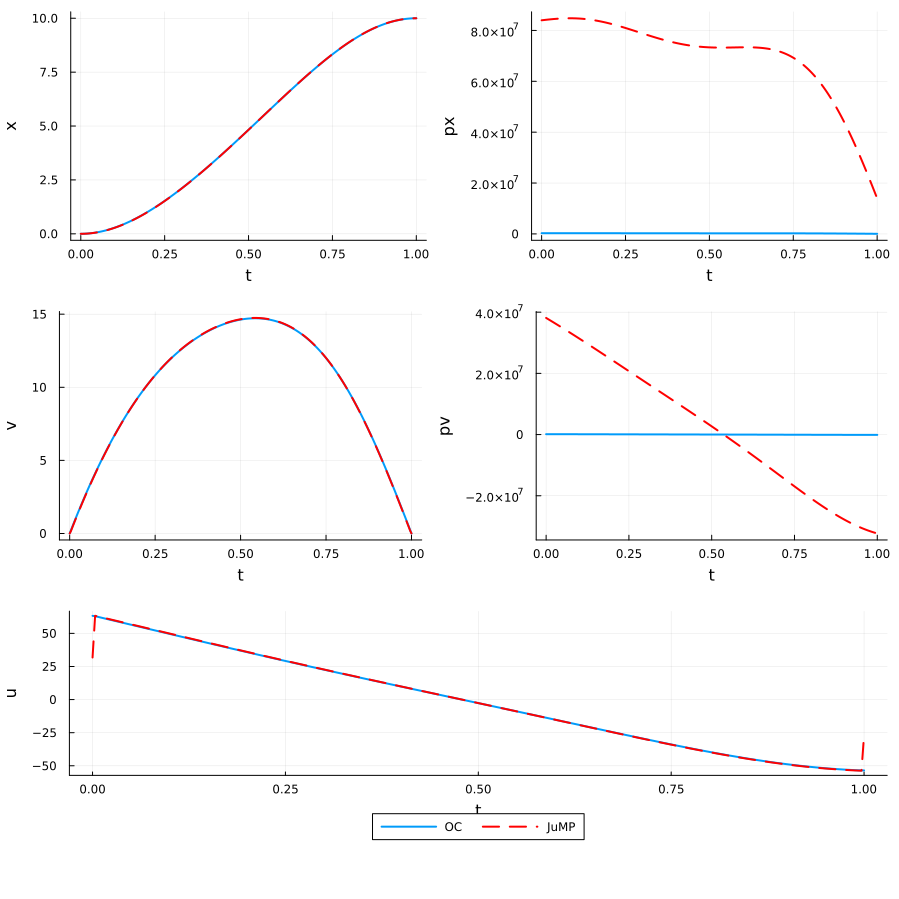

In [8]:
p_x = plot(plot(sol)[1],line = 2)
p_x = plot!(t, [ x[i] for i in 0:nh ], xlabel = "t", ylabel = "x", legend = false,line = 2, color = "red",linestyle=:dash)

p_v = plot(plot(sol)[2],line = 2)
p_v = plot!(t, [ v[i] for i in 0:nh ], xlabel = "t", ylabel = "v", legend = false,line = 2, color = "red",linestyle=:dash)

p_px = plot(plot(sol)[3],line = 2)
p_px = plot!(t, [ p[i][1] for i in 1:nh+1 ], xlabel = "t", ylabel = "px", legend = false,line = 2, color = "red",linestyle=:dash)

p_pv = plot(plot(sol)[4],line = 2)
p_pv = plot!(t, [ p[i][2] for i in 1:nh+1 ], xlabel = "t", ylabel = "pv", legend = false,line = 2, color = "red",linestyle=:dash)

p_u = plot(plot(sol)[5], label ="OC",line = 2)
p_u = plot!(t, [ u[i] for i in 0:nh ], xlabel = "t", ylabel = "u", legend = false,label = "JuMP",line = 2, color = "red",linestyle=:dash)
p_u = plot!(legend=:outerbottom, legendcolumns=2)

layout = @layout [p_x p_px; p_v p_pv; p_u]

x_plot = plot(p_x, p_px, p_v, p_pv, p_u, layout=layout)
x_plot = plot!(size = (900, 900))

display(x_plot)